In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
!pwd
!ls

/content/drive/MyDrive
 AirQualityUCI1.csv	    go1220031104.fits
 air_quality_uci2.parquet   hotel_bookings_training.csv
 air_quality_uci3.parquet   inference_pipeline.joblib
 AirQualityUCI.csv	    new_customers.csv
'Colab Notebooks'	    __pycache__
 correlación.png	    transaction_dataset_clean.csv
 Data.csv		    transaction_dataset.csv
 Funciones.py		    videojuegos.csv
 go1020011213.fits


**Vamos a probar con keras y comparar resultados.**

Para ello vamos a tomar el dataset limpio antes de aplicar el modelo(transaction_dataset_clean).

**Caraterísticas de la estructura:**

Armamos un modelo en Keras muy parecido al que se hizo a "mano". Vamos a usar:

32 entradas

1 capa oculta con 20 neuronas y activación sigmoid

Capa de salida con 2 neuronas y activación tanh

Métricas: accuracy, precision, recall, f1-score

Normalización por media y desvío estándar

Importamos las librerías necesarias

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import metrics


In [6]:
df_keras = pd.read_csv('/content/drive/MyDrive/transaction_dataset_clean.csv')

df_keras

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 avg val sent,ERC20 uniq sent token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,30.000000,54.000000,0.00000,58.000000,0.000000,1.500000e+07,2.655861e+05,2.717799e+05,39.000000
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.000000,1.000000,5.000000,0.00000,7.000000,0.000000,3.650000e+02,5.763262e+01,2.260809e+00,1.000000
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000,7.000000,0.00000,8.000000,0.000000,4.428198e+02,6.518901e+01,0.000000e+00,0.000000
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.000000,2.000000,11.000000,0.00000,11.000000,0.000000,1.141223e+04,1.555550e+03,3.804077e+03,1.000000
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.000000,23.000000,0.00000,27.000000,0.000000,9.000000e+04,4.934232e+03,1.372666e+04,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,...,0.000000,0.000000,2.000000,0.00000,2.000000,0.000000,1.337000e+00,6.685000e-01,0.000000e+00,0.000000
9837,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,0.000000,0.000000,1.000000,0.00000,1.000000,13.370000,1.337000e+01,1.337000e+01,0.000000e+00,0.000000
9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,...,0.000000,0.000000,5.000000,0.00000,5.000000,0.000000,1.500000e+03,3.006939e+02,0.000000e+00,0.000000
9839,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,...,110.939207,5.638038,7.598535,0.00344,4.901909,485.614688,1.252524e+08,4.346203e+06,6.318389e+06,1.384931


Dividimos el dasat en atributos y variable objetivo

In [8]:
# Vamos a dividir el dataset entre el valor objetivo y el resto de los atributos

X = df_keras.drop("FLAG", axis=1)                                   # Quita la columna FLAG del dataset

y = df_keras["FLAG"]                                                # Extrae la columna FLAG como la variable objetivo

Ahora vamos a dividir en datos de entrenamiento y prueba

In [9]:
from imblearn.over_sampling import SMOTE                               # Se utiliza para balancear datasets generando datos sintéticos de la clase minoritaria.
from sklearn.preprocessing import StandardScaler

# X e y ya fueron definidos como los atributos y la variable a clasificar respectivamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Aplicar SMOTE con límite de generación de datos sintéticos
#smote = SMOTE(sampling_strategy=5000/7662, random_state=42)                  # Generar datos sintéticos para alcanzar 5000 en la clase minoritaria. El parámetro sampling_strategy
                                                                             # controla cuánto sobremuestreo se aplica

#X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalización
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# One-hot encoding
y_trainB = to_categorical(y_train)
y_testB = to_categorical(y_test)

# Luego se lo lleva al rango [-1, 1]
y_trainB = 2 * y_trainB - 1
y_testB = 2 * y_testB - 1


**Definimos el modelo**

Vamos a replicar una red simple como la que se armó anteriormente: una capa oculta y una capa de salida, con funciones de activación sigmoid y tanh

In [10]:
# Crear el modelo
model = Sequential()
model.add(Dense(20, input_dim=X_train_norm.shape[1], activation='sigmoid'))    # capa oculta, con los 38 atributos de entrada
#model.add(Dense(10, activation='sigmoid'))  # Segunda capa oculta
model.add(Dense(y_trainB.shape[1], activation='tanh'))                    # capa de salida


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compilar**

Usamos sgd (descenso del gradiente estocástico), igual que en el modelo anterior, y mse como función de error (Error Cuadrático Medio) igual que el anterior.

In [11]:
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

**Entrenamiento**

In [12]:
history = model.fit(X_train_norm, y_trainB, epochs=100, verbose=1)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7802 - loss: 0.7061
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7836 - loss: 0.6626
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7746 - loss: 0.6707
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7859 - loss: 0.6348
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7734 - loss: 0.6473
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7765 - loss: 0.6332
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7862 - loss: 0.6107
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7750 - loss: 0.6224
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.6068
Epoch 10/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7788 - loss: 0.6074
Epoch 11/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7785 - loss: 0.5995
Epoch 12/100
216/216 ━━━━━━━━━━━━━━━━━━━━

**Gráfico del error**

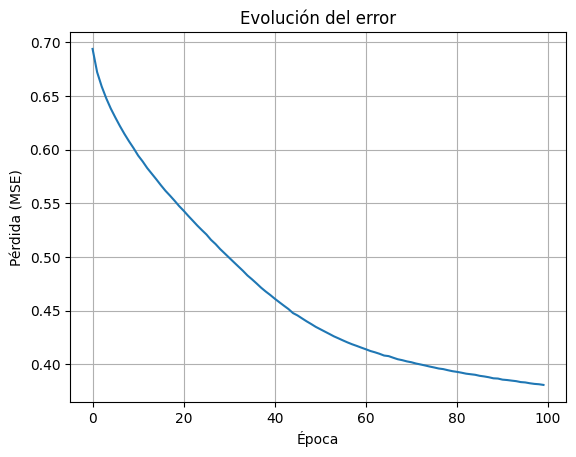

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Evolución del error')
plt.grid(True)
plt.show()


**Evaluar**

In [14]:
# Predecimos las clases
y_pred_probs = model.predict(X_train_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
acc = metrics.accuracy_score(y_train, y_pred)
print(f"Accuracy en entrenamiento: {acc:.3f}")


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy en entrenamiento: 0.857


**Matriz de confusión y análisis**

In [15]:
MM = metrics.confusion_matrix(y_train, y_pred)
print("Matriz de confusión:")
print(MM)

print("\nAciertos y errores por clase:")
for i in range(MM.shape[0]):
    aciertos = MM[i, i]
    errores = sum(MM[i, :]) - aciertos
    print(f"Clase {i}: Aciertos = {aciertos}, Errores = {errores}")

Matriz de confusión:
[[5279   80]
 [ 905  624]]

Aciertos y errores por clase:
Clase 0: Aciertos = 5279, Errores = 80
Clase 1: Aciertos = 624, Errores = 905


**Evaluar los datos de testeo**

In [16]:
# Evaluación directa (devuelve loss y accuracy)
test_loss, test_acc = model.evaluate(X_test_norm, y_testB, verbose=0)
print(f"Accuracy en test: {test_acc:.3f}")

Accuracy en test: 0.868


**Predicciones y métricas de testeo**

In [17]:
y_pred_probs = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
#y_pred = (y_pred_probs > 0.4).astype(int)

# Matriz de confusión y reporte
MM = metrics.confusion_matrix(y_test, y_pred)
print("Matriz de confusión (test):")
print(MM)

print("\nAciertos y errores por clase (test):")
for i in range(MM.shape[0]):
    aciertos = MM[i, i]
    errores = sum(MM[i, :]) - aciertos
    print(f"Clase {i}: Aciertos = {aciertos}, Errores = {errores}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matriz de confusión (test):
[[2277   26]
 [ 363  287]]

Aciertos y errores por clase (test):
Clase 0: Aciertos = 2277, Errores = 26
Clase 1: Aciertos = 287, Errores = 363


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# Predecir con el modelo
y_pred = np.argmax(model.predict(X_test_norm), axis=1)

# Imprimir matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(np.argmax(y_testB, axis=1), y_pred))

# Imprimir reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(np.argmax(y_testB, axis=1), y_pred))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matriz de confusión:
[[2277   26]
 [ 363  287]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2303
           1       0.92      0.44      0.60       650

    accuracy                           0.87      2953
   macro avg       0.89      0.72      0.76      2953
weighted avg       0.87      0.87      0.85      2953



Evidentemente al aplicar un modelo similar a la red anterior pero con keras los resultados no fueron buenos. Si bien los accuracy no están tan mal y hay poca diferencia entre ellos, el resto de las métricas, sobretodo para la clase 1, son muy malas. De la clase 1 solo acertó 287 y le erró en 363 (más de la mitad).

Se probó con una segunda capa oculta y los resultados siguen siendo igual de malos.

Matriz de confusión:

[[2277   26]

 [ 363  287]]

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2303
           1       0.91      0.44      0.59       650

    accuracy                           0.87      2953
   macro avg       0.88      0.71      0.76      2953
   
weighted avg       0.87      0.87      0.85      2953

**Se probó con smote (oversampling) y los resultados mejoraron un poco:**

Se Ganó mucho en recall y F1 para la clase 1 (lo más importante en un problema desbalanceado).

Se perdió algo de precisión en general, pero el modelo ahora es mucho más justo con la clase minoritaria.

Accuracy bajó, pero eso no importa tanto cuando hay desbalance.

Matriz de confusión:

[[1891  412]

 [  76  574]]

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2303
           1       0.58      0.88      0.70       650

    accuracy                           0.83      2953
    
   macro avg       0.77      0.85      0.79      2953

   weighted avg       0.88      0.83      0.85      2953